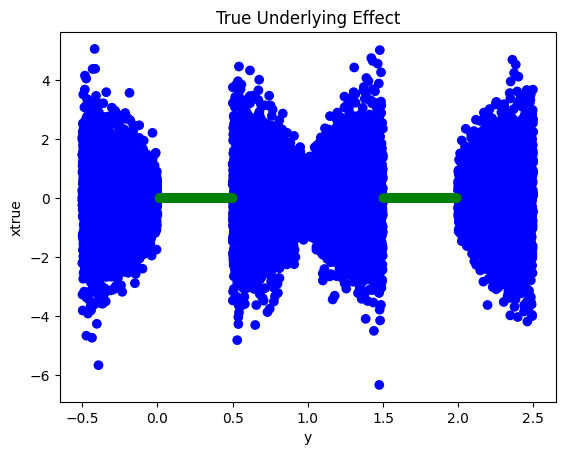

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
# Set random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Generate data
n_samples = 20000
y = np.random.uniform(-.5, 2.5, n_samples)
X = y.reshape(-1, 1)
xtrue = np.zeros_like(y)

# Apply conditions to generate xtrue based on y
for i in range(len(xtrue)):
    if (0 < y[i] < 0.5) or (1.5 < y[i] < 2):
        xtrue[i] = 0
    else:
        xtrue[i] = np.random.normal(0, scale=0.5 + 1 * abs(np.sin(np.pi * y[i])))

# Generate x and s
x = xtrue + np.random.normal(0, 1, len(xtrue))
s = np.ones_like(x)
Z = np.ones((n_samples, 1))

# Plot the results
plt.scatter(y, xtrue, c=np.where(xtrue == 0, 'green', 'blue'))
plt.title('True Underlying Effect')
plt.xlabel('y')
plt.ylabel('xtrue')
plt.show()

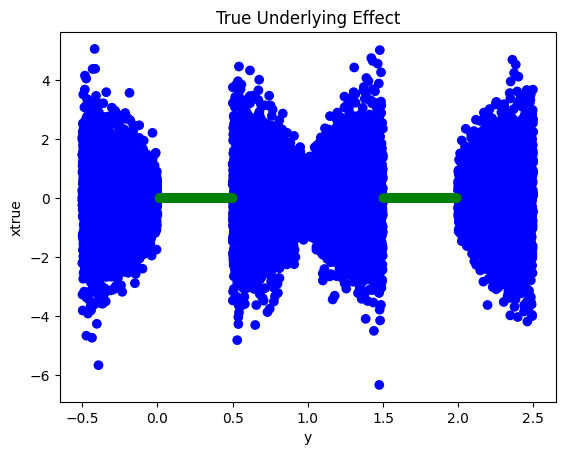

In [2]:
plt.scatter(y, xtrue, c=np.where(xtrue == 0, 'green', 'blue'))
plt.title('True Underlying Effect')
plt.xlabel('y')
plt.ylabel('xtrue')
plt.show()


In [3]:
# Assuming we have the comoR functions implemented in Python
# For now, we'll create dummy data for fit_como.data_loglik
num_classes = 20

import os
import sys
sys.path.append(r"D:\Document\Serieux\Travail\python_work\cEBNM_torch\py")
# Import utils.py directly
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
from ash import *
scale = autoselect_scales_mix_norm(betahat=x,
                                   sebetahat=np.full(x.shape[0],1),
                                       max_class=num_classes) 

 
print(scale.shape)
scale[0]=scale[2]
scale[1]=scale[2]


(20,)


In [4]:
fit_como_data_loglik = get_data_loglik_normal(betahat=x,
                                              sebetahat=np.full(x.shape[0],1),
                                               location=0*scale,
                                              scale=scale)

In [5]:
0*scale+1


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [5]:
import torch
import torch.nn as nn

# Convert data to PyTorch tensors
x_train = torch.FloatTensor(y).reshape(-1, 1) 
y_train = torch.FloatTensor(fit_como_data_loglik)

# Define the model
class SimpleNet(nn.Module):
   def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNet, self).__init__()
        
        # Shared layers with batch normalization and dropout
        self.shared_layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Heads for prediction
        self.pi_head = nn.Sequential(
            nn.Linear(hidden_size, num_classes),
            nn.Softmax(dim=1)
        )
        
        self.location_head = nn.Linear(hidden_size,  num_classes)
    
   def forward(self, x):
        shared_output = self.shared_layers(x)
        pred_pi = self.pi_head(shared_output)
        location = self.location_head(shared_output)
        return pred_pi , location

   # Custom loss function
def custom_loss(pred_pi, marginal_log_lik, penalty=0.1, epsilon=1e-10):
    """
    Compute the penalized log-likelihood function using the log-sum-exp trick for numerical stability.

    Parameters:
        pred_pi (torch.Tensor): A tensor of shape (batch_size, K) corresponding to pi_k for each sample.
        marginal_log_lik (torch.Tensor): A tensor of shape (batch_size, K) corresponding to the log-likelihoods.
        penalty (float): The penalty term.
        epsilon (float): Small constant to avoid log of zero or division by zero.

    Returns:
        torch.Tensor: The negative penalized log likelihood (for minimization purposes).
    """
    # Compute the log-sum-exp trick for log(∑ pred_pi * exp(marginal_log_lik))
    # Expand pred_pi in log-space for numerical stability
    
    log_pred_pi = torch.log(pred_pi + epsilon)  # Avoid log(0) issues

    # Compute the log-sum-exp component
    log_sum_exp = torch.logsumexp(log_pred_pi + marginal_log_lik, dim=1)

    # Compute the first sum: sum of log(inner_sum) across the minibatch (batch_size)
    first_sum = torch.sum(log_sum_exp)
    
    # Penalty term: based on the first component of pred_pi (penalty on pred_pi[:, 0])
    if penalty > 1:
        pi_clamped = torch.clamp(torch.sum(pred_pi[:, 0]), min=epsilon)
        penalized_log_likelihood_value = first_sum + (penalty - 1) * torch.log(pi_clamped)
    else:
        penalized_log_likelihood_value = first_sum

    # Return the negative of the penalized log-likelihood
    return -penalized_log_likelihood_value

In [ ]:

# Initialize model
model = SimpleNet(1, 64, num_classes)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001  ) 
# Training loop
num_epochs = 50
batch_size =  100

for epoch in range(num_epochs):
    for i in range(0, len(x_train), batch_size):
        batch_x = x_train[i:i+batch_size]
        
        pred_pi, location = model(batch_x)
        #pred_pi = model(batch_x)
        batch_y = torch.FloatTensor( get_data_loglik_normal(betahat=x[i:i+batch_size],
                                      sebetahat=np.full(x[i:i+batch_size].shape[0],1),
                                      location= location.detach() .numpy() ,  # Use .detach() before .numpy()
                                      scale=scale))
 
        
        optimizer.zero_grad() 
        loss = custom_loss(pred_pi=  pred_pi, 
                           marginal_log_lik= batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

 

Epoch [10/50], Loss: 186.9465
Epoch [20/50], Loss: 186.9330
Epoch [30/50], Loss: 186.9331
Epoch [40/50], Loss: 186.9328
Epoch [50/50], Loss: 186.9326


In [ ]:
x_train

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from posterior_computation import posterior_mean_norm  # Ensure this import works

# [Previous code for data generation and model definition remains the same]

# After training the model, compute the posterior mean
model.eval()
with torch.no_grad():
     all_pi_values,all_location = model(x_train)
    #all_pi_values = model(x_train)

all_pi_values_np = all_pi_values.numpy()
all_location_np =all_location.numpy()
 
 
 

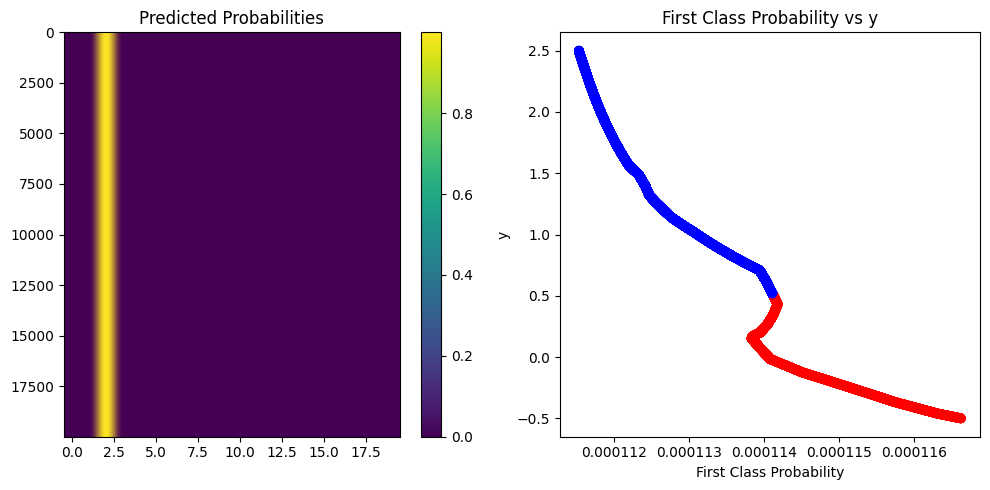

In [9]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(all_pi_values, aspect='auto')
plt.title('Predicted Probabilities')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(all_pi_values[:, 0], y, c=['red' if yi < 0.5 else 'blue' for yi in y])
plt.title('First Class Probability vs y')
plt.xlabel('First Class Probability')
plt.ylabel('y')

plt.tight_layout()
plt.show()

ValueError: x and y must be the same size

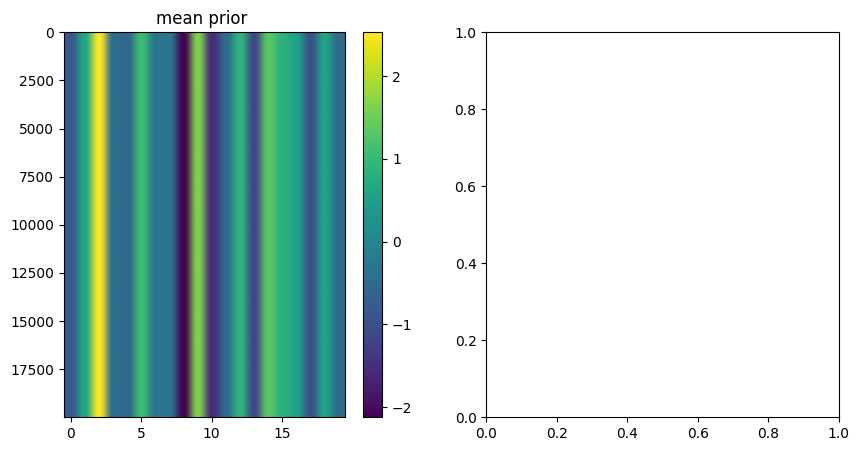

In [10]:
# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(all_location, aspect='auto')
plt.title('mean prior ')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(all_location , y, c=['red' if yi < 0.5 else 'blue' for yi in y])
plt.title('First Class Probability mean vs y')
plt.xlabel('First Class Probability mean')
plt.ylabel('y')

plt.tight_layout()
plt.show()

In [21]:
betahat=np.array([x[i]])
sebetahat=np.array([s[i]])
log_pi=np.log(all_pi_values_np[i, :])
location= all_location_np[i,:]
scale= scale  # Assuming this is available from earlier in your code


In [22]:
from utils import *
from numerical_routine import *
from distribution_operation import *
from posterior_computation import *
from ash import *

In [11]:
est_post = np.zeros(n_samples)
for i in range(n_samples):
  
    est_post[i] = posterior_mean_norm(
        betahat=np.array([x[i]]),
        sebetahat=np.array([s[i]]),
        log_pi=np.log(all_pi_values_np[i, :]),
        location= 0*all_location_np[i,:],
        scale= scale  # Assuming this is available from earlier in your code
    ).post_mean
 

C:\Users\WD\AppData\Local\Temp\ipykernel_6524\2802869422.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  est_post[i] = posterior_mean_norm(


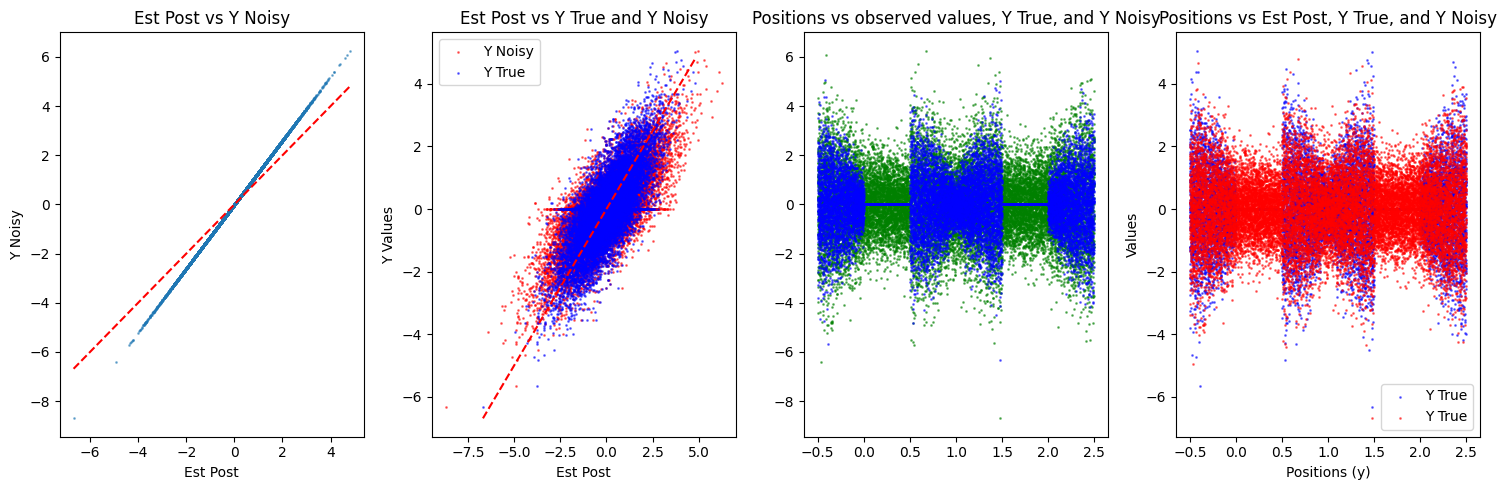


Mean Squared Error:
MSE (Est Post vs Y Noisy): 1.0125
MSE (Ash Post vs Y True): 0.4658
MSE (Est Post vs Y True): 0.6431


In [12]:
plt.figure(figsize=(15, 5))

# Plot 1: Est Post vs Y Noisy
plt.subplot(1, 4, 1)
plt.scatter(est_post, x, alpha=0.5, s=1)
plt.title('Est Post vs Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Noisy')
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 2: Est Post vs Y True
plt.subplot(1, 4, 2)
plt.scatter(x, xtrue, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(est_post, xtrue, alpha=0.5, s=1, label='Y True', color='blue')
plt.title('Est Post vs Y True and Y Noisy')
plt.xlabel('Est Post')
plt.ylabel('Y Values')
plt.legend()
plt.plot([min(est_post), max(est_post)], [min(est_post), max(est_post)], 'r--')

# Plot 3: Positions vs Est Post, Y True, and Y Noisy
plt.subplot(1, 4, 3)
#plt.scatter(y, y_n_np, alpha=0.5, s=1, label='Y Noisy', color='red')

plt.scatter(y, x, alpha=0.5, s=1, label='Y True', color='green')
plt.scatter(y, xtrue, alpha=0.5, s=1, label='Y True', color='blue')
#plt.scatter(y, x, alpha=0.5, s=1, label='Y True', color='green')
plt.title('Positions vs observed values, Y True, and Y Noisy')
plt.subplot(1,4,4)
plt.scatter(y, xtrue, alpha=0.5, s=1, label='Y True', color='blue')

plt.scatter(y, est_post, alpha=0.5, s=1, label='Y True', color='red')
plt.title('Positions vs Est Post, Y True, and Y Noisy')
plt.xlabel('Positions (y)')
plt.ylabel('Values')
plt.legend()

plt.tight_layout()
plt.show()
res_ash = ash( x, np.full(x .shape[0],1))
# Print some statistics
 
# Calculate and print MSE
mse_noisy = np.mean((xtrue - x)**2)
mse_ash = np.mean (( res_ash.post_mean - xtrue)**2)

mse_true = np.mean((est_post - xtrue)**2)
print(f"\nMean Squared Error:")
print(f"MSE (Est Post vs Y Noisy): {mse_noisy:.4f}")
print(f"MSE (Ash Post vs Y True): {mse_ash:.4f}")
print(f"MSE (Est Post vs Y True): {mse_true:.4f}")



In [16]:
from ash import *
res_ash = ash( x, np.full(x .shape[0],1))

In [ ]:
plt.scatter(y, xtrue, alpha=0.5, s=1, label='Y True' )
plt.scatter(y, res_ash.post_mean, alpha=0.5, s=1, label='Y True' )
plt.scatter(y, est_post, alpha=0.5, s=1, label='Y True' )

